# Wine quality analysis

In [21]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate


## Summary

## Introduction

Red wine has a long history and is favored by people around the world today. Depending on the raw materials and process, its quality can vary significantly, and only professional sommeliers can tell the differences. As the development of technology, it is now possible to quantify certain metrics of red wine. Here we want to find out how the metrics influence the quality. Using a red wine dataset containing quality rates and 11 kinds of metrics, we try to implement a machine learning algorithm to predict the quality of a bottle of red wine. 

## Methods & Results

Read the red wine quality dataset

In [2]:
data = pd.read_csv("data/winequality-red.csv", sep=';')
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


Show the statistical information of dataset

In [3]:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

We can see there are 11 features deciding the quality of red wine, which is rated from 0 to 10. In this dataset, the score of quility ranges from 3 to 8, and the mean is about 5.6. Thus, we can suppose red wines with 6 or higher quality scores as "good" (marked as 1) and the others as "not good" (marked as 0). 

In [4]:
data["is_good"] = (data["quality"]>5)*1
data.head(5)

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,is_good
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,1
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,0


Data spliting

In [14]:
train_data, test_data = train_test_split(data, train_size=0.8, random_state=123)
x_train = (train_data.iloc[:, :-2])
y_train = (train_data["is_good"])
x_test = (test_data.iloc[:, :-2])
y_test = (test_data["is_good"])

1076    1
847     1
582     0
172     1
779     0
       ..
1122    1
1346    0
1406    1
1389    0
1534    1
Name: is_good, Length: 1279, dtype: int64

EDA

We want to see which features might be correlated with our target variable. We will do this by creating faceted histograms. 

In [72]:
import altair as alt

numeric_columns = numeric_columns = [
    'fixed acidity', 
    'volatile acidity', 
    'citric acid', 
    'residual sugar', 
    'chlorides', 
    'free sulfur dioxide', 
    'total sulfur dioxide', 
    'density', 
    'pH', 
    'sulphates', 
    'alcohol'
]

alt.Chart(train_data).mark_bar(opacity=0.7).encode(
    x=alt.X(alt.repeat()).type('quantitative').bin(maxbins=40),
    y=alt.Y('count()').stack(False),
    color='is_good:N'
).repeat(numeric_columns, columns = 3)

alt.RepeatChart(...)

We can see from our intitial EDA, that there is no noticeable overlap for the numeric variables in terms of whether a wine is considered to be good quality or not. This indicates that we might not need to drop any features. 

Model Fitting and Hyperparameter Optimization


We will fit a decision tree model where our aim is to correctly classify if our model can predict the instances of a wine being good quality or not. We will optimize the hyperparameter max depth. And the metric we will look at will be the variation in mean train and test scores. We will run 5 fold CV with different max depths, and then plot the corresponding mean train accuracy and cross validation accuracies and determine the sweet spot of which max depth is the best to use. 


<Axes: xlabel='depth'>

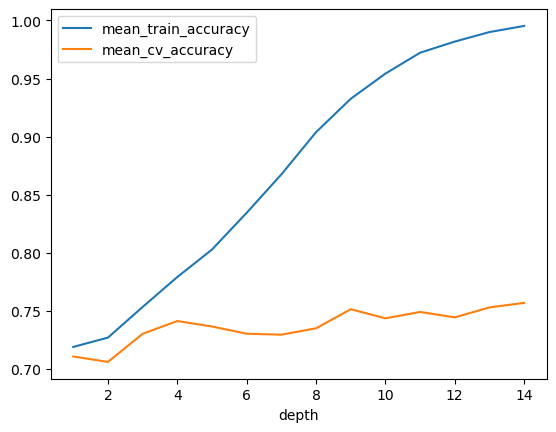

In [73]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_validate
import pandas as pd

depths = np.arange(1, 15, 1)
depths

results_dict = {
    "depth": [],
    "mean_train_accuracy": [],
    "mean_cv_accuracy": []}
param_grid = {"max_depth": np.arange(1, 15, 1)}

for depth in param_grid["max_depth"]:
    model = DecisionTreeClassifier(max_depth=depth, random_state = 123)
    scores = cross_validate(model, x_train, y_train, cv=5, return_train_score=True)
    results_dict["depth"].append(depth)
    results_dict["mean_cv_accuracy"].append(np.mean(scores["test_score"]))
    results_dict["mean_train_accuracy"].append(np.mean(scores["train_score"]))

results_df = pd.DataFrame(results_dict).set_index('depth')


results_df
results_df[["mean_train_accuracy", "mean_cv_accuracy"]].plot()

We can see that a max depth of 4 seems to be the best max depth to use, this is because at lower values such as 1 and 2, our train score is not as high, but at higher values our train score is really high, with a high difference in train and test score, which indicates that the model is overfitting. Ideally, a max depth of 4 seems to be the best to use here.

In [62]:
best_model = DecisionTreeClassifier(max_depth=4, random_state=123)
best_model.fit(x_train, y_train) 
best_model.score(x_test, y_test)

0.6875

## Discussion

## References